# Working with spiking JAX layers

In [32]:
## Housekeeping and imports

# - Numpy
import numpy as np

# - Matplotlib and plotting config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]

# - Switch off warnings
import warnings
warnings.filterwarnings('ignore')

## Available layers

### Layer dynamics
The membrane and synaptic dynamics evolve under the equations

$$\tau_{syn} \dot{I}_{syn} + I_{syn} = 0$$
$$\tau_{mem} \dot{V}_{mem} + V_{mem} = I_{syn} + I_{in}(t)\cdot W_{in} + b + \sigma\zeta(t)$$
$$I_{syn} = I_{syn} + S_{in}(t) \cdot W_{in}$$

where $I_{syn}$ is the $N$ vector of synaptic input currents; $V_{mem}$ is the $N$ vector of membrane potentials of the neurons; $b$ is the $N$ vector of bias currents; $\sigma\zeta(t)$ is a white noise process with standard deviation $\sigma$, injected independently into each neuron; $\tau_{syn}$ and $\tau_{mem}$ are the $N$ vectors of synaptic and membrane time constants, respectively; and $W_{in}$ is the $[N_{in} \times N]$ input weight matrix.

The input spike train $S_{in}(t)$ is $1$ when a spike is present on an input channel. When an input spike arrives on an input channel, the synaptic current variable is incremented by $1$ then decays to zero.

The input currents $I_{in}(t)$ define input channels injeted onto neuron membranes via the input weight matrix $W_{in}$.

#### Spiking
When the membrane potential for neuron $j$, $V_{mem, j}$ exceeds the threshold voltage $V_{thr} = 0$, then the neuron $j$ emits a spike. These events are collected into the binary spike variable $S_{rec}(t)$.

$$S_{rec}(t) = H(V_{mem} - V_{thr})$$
$$I_{syn} = I_{syn} + S_{rec}(t) \cdot W_{rec}$$
$$V_{mem} = V_{mem} - S_{rec}(t)$$

Where $H(x)$ is a Heaviside function for spike production (with a pseudo gradient described below), $H(x) = x > 0$; and $W_{rec}$ is the matrix of recurrent synaptic weights.

All neurons therefore share a common resting potential of `0`, a firing threshold of `0`, and a subtractive reset of `-1`. The bias current for each neuron is set to `-1` by default.

The spiking events emitted by the layer $S_{rec}(t)$ are returned as the output of the

#### Surrogate signals for back-propagation
To assist with training, the layers describe here use surrogate signals in two ways:
 - To generate a non-spiking weighted output from $V_{mem}$, which can be used to train the layer to approximate a target representation
 - On spike generation via $H(x)$, used to propagate errors backwards through time
 
A surrogate $U(t)$ is generated from the layer, with $U(t) = \textrm{sig}\left[V_{mem}(t)\right]$, where $\textrm{sig}(x)$ is the sigmoid function $\textrm{sig}(x) = \left[1 + \exp(x)\right]^{-1}$. The surrogate weighted output of a layer is given by

$$O(t) = U(t) \cdot W_{out}$$

Where $W_{out}$ is the $[N \times N_{out}]$ output weight matrix.
 
$H(x)$ is implemented internally such that it becomes differentiable in the backwards pass.

* Forward pass: $H(x) = \max\left[0, \textrm{floor}(x + 1)\right]$. This form permits multiple events for each neuron per time step.
* Backwards pass: $\textrm{d}H(x)/\textrm{d}x = (x > -0.5)$

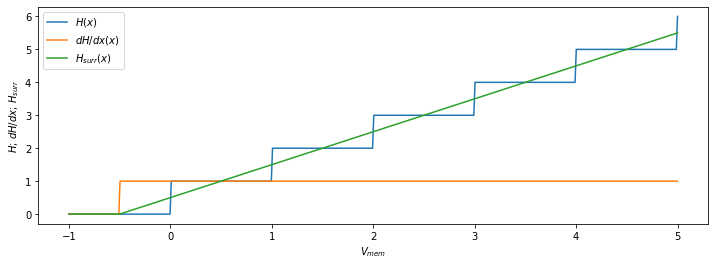

In [28]:
def H(x):
    return np.clip(np.floor(x + 1.0), 0.0, np.inf)

def dHdx(x):
    return x > -0.5

def H_surrogate(x):
    return np.clip(x+.5, 0.0, np.inf)

x = np.linspace(-1., 5., 500)

plt.figure()
plt.plot(x, H(x), x, dHdx(x), x, H_surrogate(x))
plt.legend(['$H(x)$', '$dH/dx(x)$', '$H_{surr}(x)$'])
plt.xlabel('$V_{mem}$')
plt.ylabel('$H$; $dH/dx$; $H_{surr}$');

In other words, $\textrm{d}H(x)/\textrm{d}x(x)$ acts as though each neuron is a linear-threshold unit.

### Spiking versus current inputs
The classes `RecLIFJax` and `RecLIFJax_IO` receive spiking inputs; the `.evolve()` method for these layers accept `TSEvent` time series obejcts, describing spiking activity of the input channels over time.

The classes `RecLIFCurrentInJax` and `RecLIFCurrentInJax_IO` receive direct current injection inputs; the `.evolve()` method for these layers accept `TSContinuous` time series objects, describing instantaneous currents on the input channels.

### Spiking versus surrogate outputs
The classes `RecLIFJax` and `RecLIFCurrentInJax` return spiking activity of the layer neurons as `TSEvent` objects from the `.evolve()` method.

The classes `RecLIFJax_IO` and `RecLIFCurrentInJax_IO` return (weighted) surrogate non-spiking activity as `TSContinuous` objects from the `.evolve()` method.

In both cases, several interal signals of the layers are monitored during evolution, and these are available as object attributes after evolution.

## Building and simulating a spiking recurrent layer
We'll start by building a spiking recurrent layer `.RecLIFJax`, which accepts spiking inputs and generates spiking outputs. `.RecLIFJax` is imported from `rockpool.layers`.

In [112]:
## -- Import the recurrent layer
from rockpool.layers import RecLIFJax
from rockpool import TSEvent, TSContinuous

In [116]:
# - Build a recurrent layer
num_neurons = 100
dt = 1e-3

weights_rec = np.random.randn(num_neurons, num_neurons)
tau_mem = np.random.rand(num_neurons) * 100e-3 + 50e-3
tau_syn = np.random.rand(num_neurons) * 100e-3 + 50e-3

lyrLIF = RecLIFJax(weights_rec, tau_mem, tau_syn, 
                   name = 'Recurrent LIF layer', dt = dt)
print(lyrLIF)

RecLIFJax object: "Recurrent LIF layer" [100 TSEvent in -> 100 internal -> 100 TSEvent out]


We'll generate a Poisson input signal independently for each of the layer neurons, with a sinusoidal modulation.

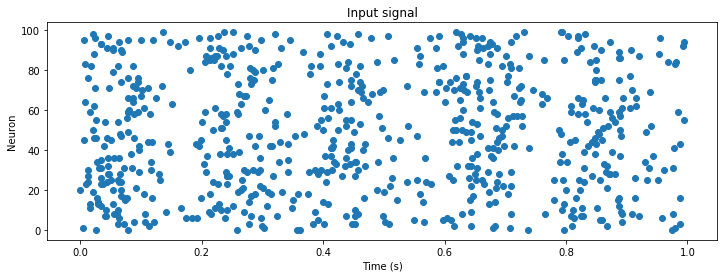

In [115]:
# - Build an input signal
input_duration = 1.
mod_freq = 5.
min_rate = 3.
max_rate = 10.

# - Generate a sinusoidal instantaneous rate
time_base = np.arange(0, input_duration, dt)
sinusoid = (np.sin(time_base * 2*np.pi * mod_freq)/2. + .5) * (max_rate - min_rate) + min_rate
sinusoid_ts = TSContinuous(time_base, sinusoid)

# - Generate Poisson spiking inputs
raster = np.random.rand(len(time_base), num_neurons) < np.tile(sinusoid * dt, (num_neurons, 1)).T
spikes = np.argwhere(raster)
input_sp_ts = TSEvent(time_base[spikes[:, 0]], spikes[:, 1])

# - Plot the input events
plt.figure()
input_sp_ts.plot()
plt.xlabel('Time (s)')
plt.ylabel('Neuron')
plt.title('Input signal');

In [121]:
output_ts = lyrLIF.evolve(duration=1.)

ValueError: TSContinuous `unnamed`: New samples matrix must have the same number of samples as `.times`.

In [ ]:
output_ts.plot()